## Movie Recommender Development

In [118]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import scipy

ModuleNotFoundError: No module named 'scipy'

In [119]:
!pip install scipy

In [92]:
ratingspath = os.path.join("..","..","data","ml-latest","ratings.csv")
ratings = pd.read_csv(ratingspath)

moviespath = os.path.join("..","..","data","ml-latest","movies.csv")
movies = pd.read_csv(moviespath)


In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [53]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II (1995),Comedy,1995.0


In [46]:
# extracting date
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True) 

In [48]:
movies.year = pd.to_datetime(movies.year, format = "%Y")
# removing any NAs that may result in decimals
movies.year = movies.year.dt.year
# removing year at end of title
#movies.title = movies.title.str[:-7] 

In [60]:
# all different types of genre
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique,columns=['genre'])

# creating boolean columns for each genre
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres',inplace=True, axis=1)

In [87]:
# converting timestamp to date type
ratings.timestamp = pd.to_datetime(ratings.timestamp,infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

In [88]:
movies.dropna(inplace=True)
ratings.dropna(inplace=True)

Text(0.5, 1.0, 'Movies per Year')

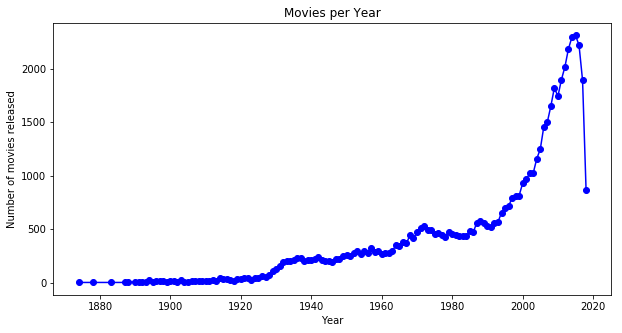

In [100]:
# temp df
tdf = movies[['movieId','year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(tdf.year.first(),tdf.movieId.nunique(),"b-o")


# tdf = ratings[['rating','timestamp']].groupby('timestamp')
# ax2 = ax1.twinx()
# ax2.plot(tdf.timestamp.first(),tdf.rating.count(),'r-o')
ax1.set_ylabel('Number of movies released')
ax1.set_xlabel('Year')
plt.title('Movies per Year')

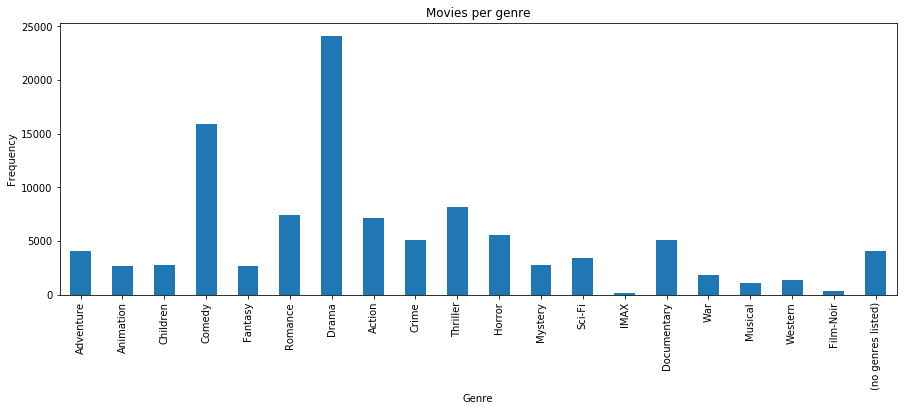

In [108]:
plt.figure(figsize = (15,5))
tdf = movies[['movieId','year']].groupby('year')
df = pd.DataFrame()

# get counts of each genre
for genre in genres_unique.genre:
    tdf = movies[movies[genre]][['movieId','year']].groupby('year')
    df[genre] = tdf.movieId.nunique().cumsum()

df.fillna(method='ffill',inplace=True)

barlist = df.iloc[-1].plot.bar()
plt.title('Movies per genre')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()

C:\Users\Sabarish\.conda\envs\movieRec\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


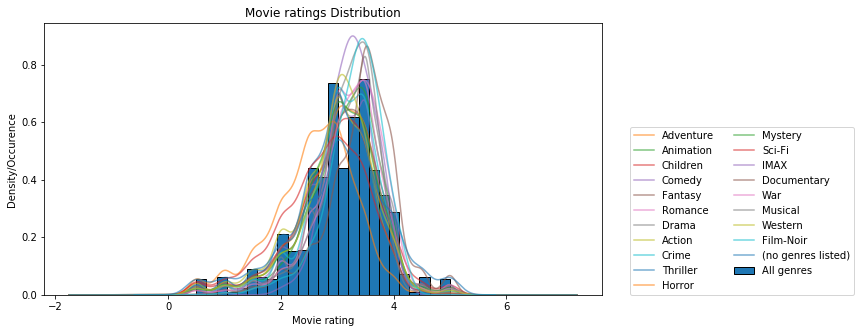

In [121]:
tdf = ratings[['movieId','rating']].groupby('movieId').mean()

rating_stats = []

# plot histogram of all ratings
tdf.hist(bins=25,label='All genres',grid=False,edgecolor='black',normed=True,figsize=(10,5))

for genre in genres_unique.genre:
    tdf = movies[movies[genre]==True]
    tdf = ratings[ratings.set_index('movieId').index.isin(tdf.set_index('movieId').index)]
    tdf = tdf[['movieId','rating']].groupby('movieId').mean()
    tdf.rating.plot(grid=False,alpha=0.6,kind='kde',label=genre)
    avg = tdf.rating.mean()
    std = tdf.rating.std()
    rating_stats.append((genre,avg,std))
plt.legend(loc=(1.05,0),ncol=2)
plt.xlabel('Movie rating')
plt.ylabel('Density/Occurence')
plt.title('Movie ratings Distribution')
plt.show()

In [126]:
import urllib.request

print('Beginning file download with urllib2...')

url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'  
urllib.request.urlretrieve(url, 'C:\\Users\\Sabarish\\Downloads') 

Beginning file download with urllib2...


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Sabarish\\Downloads'

In [125]:
!conda install urllib

'conda' is not recognized as an internal or external command,
operable program or batch file.
